# Project Description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.
Rusty Bargain is interested in:

- the quality of the prediction
- the speed of the prediction
- the time required for training

In [1]:
pip install xgboost

In [2]:
%%time
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import catboost as cb
from catboost import CatBoostRegressor
import xgboost
from xgboost import XGBRegressor
import seaborn as sns
import plotly.express as px
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt


CPU times: total: 14.6 s
Wall time: 21 s


# Download and look at the data.

In [3]:
%%time
try:
    path='C:\\Users\\aviv\\Downloads\\car_data.csv'
    data = pd.read_csv(path)
    print(data.head())
    
except:
    path = '/datasets/car_data.csv'
    data = pd.read_csv(path)
    print(data.head())

        DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

        DateCreated  NumberOfPictures  PostalCode          LastSeen  
0  24/03/2016 00:00               

In [4]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

let's look at missing values:

In [5]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

all the missing values are categorical, inserting 'unknown' instead

In [6]:
data.fillna(value = 'unknown',inplace=True)
data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

i would change the columns that represent dates to date-type but that would take forever. instead i will drop these columns when splitting the dataset, leaving the registration month and year as they are, hoping that those columns will give the models enough to work with.

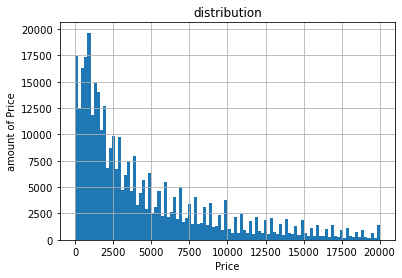

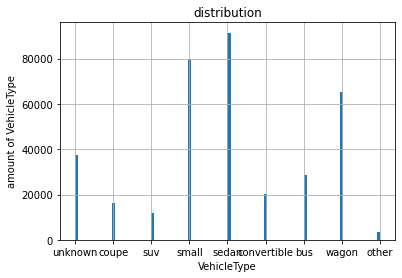

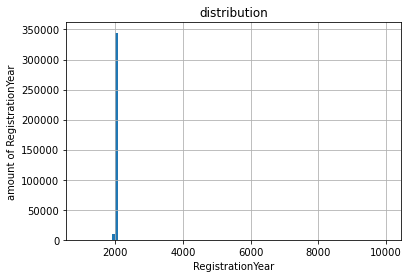

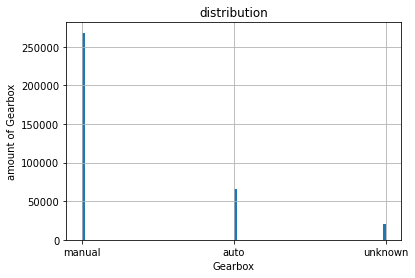

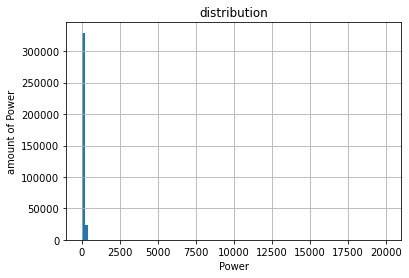

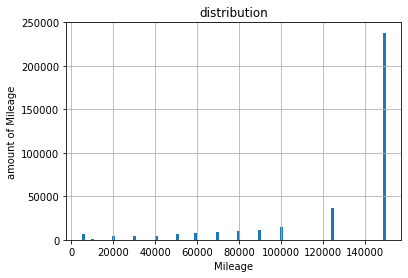

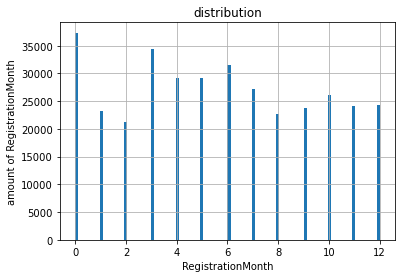

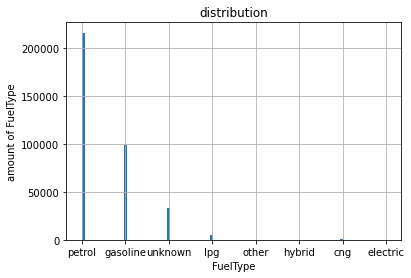

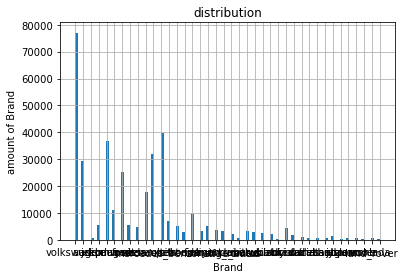

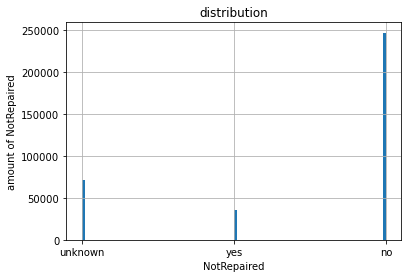

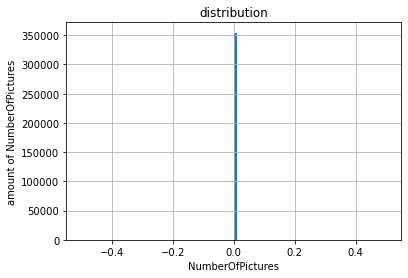

In [7]:
feats = ['Price', 'VehicleType',
 'RegistrationYear', 'Gearbox', 'Power', 'Mileage', 'RegistrationMonth',
 'FuelType', 'Brand', 'NotRepaired', 'NumberOfPictures']
for feature in feats:
    fig = data[feature].hist(bins=100)
    fig.set_ylabel(f'amount of {feature}')
    fig.set_xlabel(feature)
    fig.set_title('distribution')
    plt.show()


things to look into:
- prices of zero value i'll drop the rows as they don't hold any predictive value V
- vehicle types - merge 'other' and 'unknown' values V
- registration year - zoom in to see actual distribution and problems
- power - zoom in
- registration month - zero values - i'm thinking setting them to the median instead of dropping the rows so as to not lose the predictive value V
- fueltype - merge 'unknown' and 'other' values V
- brand - zoom in
- number of pictures - zero all over the board so the column should be dropped entirely (it won't even matter) V

left:
zoom ins -
RegistrationYear, Power, Brand

In [8]:

data.drop(data[data.Price == 0].index, inplace=True)
data[data['Price']==0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [9]:

data.loc[ data['VehicleType'] == 'other', 'VehicleType'] = 'unknown'
data[data['VehicleType']=='other']
data.loc[ data['FuelType'] == 'other', 'FuelType'] = 'unknown'
data[data['FuelType']=='other']

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [10]:
median_month = data[data['RegistrationMonth']!=0]['RegistrationMonth'].median()
data.loc[ data['RegistrationMonth'] == 0 , 'RegistrationMonth'] = median_month
data[data['RegistrationMonth']==0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [11]:
data.drop("NumberOfPictures", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        343597 non-null  object
 1   Price              343597 non-null  int64 
 2   VehicleType        343597 non-null  object
 3   RegistrationYear   343597 non-null  int64 
 4   Gearbox            343597 non-null  object
 5   Power              343597 non-null  int64 
 6   Model              343597 non-null  object
 7   Mileage            343597 non-null  int64 
 8   RegistrationMonth  343597 non-null  int64 
 9   FuelType           343597 non-null  object
 10  Brand              343597 non-null  object
 11  NotRepaired        343597 non-null  object
 12  DateCreated        343597 non-null  object
 13  PostalCode         343597 non-null  int64 
 14  LastSeen           343597 non-null  object
dtypes: int64(6), object(9)
memory usage: 41.9+ MB


zoom into: RegistrationYear, Power, Brand

In [12]:
data['RegistrationYear'].value_counts().index.sort_values()


Int64Index([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600,
            ...
            7000, 7100, 7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999],
           dtype='int64', length=140)

we have years in the future and distant past, so i'll just set these years to median of the column

In [13]:
median_year = data[(1970<data['RegistrationYear']) & (data['RegistrationYear']<2023)]['RegistrationYear'].median()

In [14]:
data.loc[ (2022<data['RegistrationYear']) | (1970> data['RegistrationYear']), 'RegistrationYear'] = median_year
data[data['RegistrationYear']==2023]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen


onto horse power values.
according to:
https://www.autolist.com/guides/average-car-horsepower
we shouldn't expect to see horsepower values below 100 and above 500

In [15]:
data['Power'].value_counts()

0       36360
75      23319
60      15465
150     14170
101     12960
        ...  
519         1
2461        1
6006        1
5815        1
1241        1
Name: Power, Length: 701, dtype: int64

adjusting to median values:

In [16]:
median_power = data[(100<data['Power']) & (data['Power']<500)]['Power'].median()

In [17]:
data.loc[ (500<data['Power']) | (100> data['Power']), 'Power'] = median_power

In [18]:
data[data['Power']==2023]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen


onto brand values:

In [19]:
data['Brand'].value_counts()

volkswagen        74413
opel              38530
bmw               35809
mercedes_benz     31359
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2273
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: Brand, dtype: int64

nothing seems out of the ordinary here.

**Take note of the encoding of categorical features for simple algorithms. LightGBM and CatBoost have their implementation, but XGBoost requires OHE.**

In [20]:
data_ohe = pd.get_dummies(data.drop(columns=['DateCrawled','DateCreated','LastSeen']), drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,140,150000,6,70435,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,5,66954,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,140,150000,6,91074,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,140,90000,7,60437,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Train different models with various hyperparameters (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.

On your own, work with the LightGBM library and use its tools to build gradient boosting models.

ideally, your project should include linear regression for a sanity check, a tree-based algorithm with hyperparameter tuning (preferably, random forrest), LightGBM with hyperparameter tuning (try a couple of sets), and CatBoost and XGBoost with hyperparameter tuning (optional).

use RMSE metric

You can use a special command to find the cell code runtime in Jupyter Notebook. Find that command.

Since the training of a gradient boosting model can take a long time, change only a few model parameters.

In [69]:
performance = {}

## Linear regression sanity check


In [47]:
x_ohe = data_ohe.drop(['Price'], axis=1)
y_ohe = data_ohe['Price']

x_train_ohe, x_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(
    x_ohe, y_ohe, test_size=0.4, random_state=12345)
x_valid_ohe, x_test_ohe, y_valid_ohe, y_test_ohe = train_test_split(x_valid_ohe, y_valid_ohe, test_size=0.5,
                                                                           random_state=12345)

In [48]:
#x = data_ohe.drop('Price',axis=1) #,'DateCrawled','LastSeen','DateCreated']
#y = data_ohe.Price
# train and test split
#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=12345)


In [49]:
%%time
model = LinearRegression()# initialize model constructor
model.fit(x_train_ohe, y_train_ohe) # train model on training set


CPU times: total: 14.6 s
Wall time: 9.3 s


LinearRegression()

In [50]:
%%time
pred_valid = model.predict(x_valid_ohe)# get model predictions on validation set
result = mean_squared_error(y_valid_ohe,pred_valid)**0.5 # calculate RMSE on validation set
print("RMSE of the linear regression model on the validation set:", result)

RMSE of the linear regression model on the validation set: 2645.0101071597705
CPU times: total: 406 ms
Wall time: 371 ms


RMSE more than 2600, CPU time almost 15 secs.

In [70]:
performance.update({'LinearRegression':(2600, 15)})

## Random forest with hyperparameter tuning

In [51]:
%%time
state = np.random.RandomState(12345)
model = RandomForestRegressor(n_estimators = 3, max_depth = 6, random_state= state)

model.fit(x_train_ohe, y_train_ohe) # train model on training set


CPU times: total: 19.1 s
Wall time: 19.5 s


RandomForestRegressor(max_depth=6, n_estimators=3,
                      random_state=RandomState(MT19937) at 0x28C9C760E40)

In [52]:
%%time
pred_valid = model.predict(x_valid_ohe)# get model predictions on validation set
result = mean_squared_error(y_valid_ohe,pred_valid)**0.5 # calculate RMSE on validation set
print("RMSE of the Random Forest Regression model on the validation set:", result)

RMSE of the Random Forest Regression model on the validation set: 2376.6849304883785
CPU times: total: 609 ms
Wall time: 649 ms


In [53]:
%%time
state = np.random.RandomState(12345)
model = RandomForestRegressor(n_estimators = 5, max_depth = 6, random_state= state)

model.fit(x_train_ohe, y_train_ohe) # train model on training set


CPU times: total: 34.6 s
Wall time: 37.5 s


RandomForestRegressor(max_depth=6, n_estimators=5,
                      random_state=RandomState(MT19937) at 0x28C95BCB040)

In [54]:
%%time
pred_valid = model.predict(x_valid_ohe)# get model predictions on validation set
result = mean_squared_error(y_valid_ohe,pred_valid)**0.5 # calculate RMSE on validation set
print("RMSE of the Random Forest Regression model on the validation set:", result)

RMSE of the Random Forest Regression model on the validation set: 2377.914419028111
CPU times: total: 578 ms
Wall time: 769 ms


forest regressor did a little better with smaller RMSE of 2377, in twice the amount of time elapsed than with the linear regression.

In [71]:
performance.update({'RandomForestRegressor':(2377, 34)})

## LightGBM with hyperparameter tuning

In [55]:
categorical_feats = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


In [56]:
x = data.drop(['Price', 'DateCrawled', 'DateCreated','LastSeen'], axis=1)
y = data['Price']

for c in categorical_feats:
    x[c] = x[c].astype('category')

x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.4, random_state=12345)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5,
                                                                           random_state=12345)

In [58]:
%%time

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 30,
    'learning_rate': 0.5,
    'metric': {'rmse'},
    'verbose': 2
}

# loading data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
cat_feature = []
model = lgb.train(params,
                  num_boost_round = 30,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.735598
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.142133
[LightGBM] [Debug] init for col-wise cost 0.018312 seconds, init for row-wise cost 0.047392 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 206158, number of used features: 11


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4558.047342
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[1]	valid_0's rmse: 3076.56
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[2]	valid_0's rmse: 2466.15
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[3]	valid_0's rmse: 2161.49
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[4]	valid_0's rmse: 2018.24
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 7
[5]	valid_0's rmse: 1953.49
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[6]	valid_0's rmse: 1913.52
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[7]	valid_0's rmse: 1887.25
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[8]	valid_0's rmse: 1866.98
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[9]	valid_0's rmse: 1856.02
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 12
[10]	valid_0's rmse: 1848.04
[LightGBM

In [59]:
%%time

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 50,
    'learning_rate': 0.5,
    'metric': {'rmse'},
    'verbose': 2
}

# laoding data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
cat_feature = []
model = lgb.train(params,
                  num_boost_round = 30,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.735598
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.142133
[LightGBM] [Debug] init for col-wise cost 0.010312 seconds, init for row-wise cost 0.021359 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 206158, number of used features: 11
[LightGBM] [Info] Start training from score 4558.047342
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[1]	valid_0's rmse: 3003.54
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[2]	valid_0's rmse: 2361.13
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[3]	valid_0's rmse: 2078.13
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[4]	valid_0's rmse: 1940.68
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[5]	valid_0's rmse: 1878.82
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[6]	valid_0's rmse: 1844.9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[7]	valid_0's rmse: 1817.44
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[8]	valid_0's rmse: 1809.43
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[9]	valid_0's rmse: 1797.69
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[10]	valid_0's rmse: 1781.68
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 15
[11]	valid_0's rmse: 1770.86
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[12]	valid_0's rmse: 1762.53
[LightGBM] [Debug] Trained a t

best variant here did a much better job than the random forest and the linear regression in less time than it took the linear regression.

RMSE 1713, 5 seconds

In [72]:
performance.update({'LightGBM':(1713,5)})

## CatBoost  with hyperparameter tuning (OPTIONAL)

In [60]:
%%time
model = CatBoostRegressor(iterations=30,
                          cat_features=[0,2,4,7,8,9],
                         verbose=1,
                         eval_metric='RMSE')
model.fit(x_train, y_train)


Learning rate set to 0.5
0:	learn: 3273.7112412	total: 163ms	remaining: 4.72s
1:	learn: 2705.2370078	total: 336ms	remaining: 4.7s
2:	learn: 2431.2654953	total: 504ms	remaining: 4.54s
3:	learn: 2301.3579909	total: 627ms	remaining: 4.08s
4:	learn: 2198.8572833	total: 783ms	remaining: 3.91s
5:	learn: 2162.3149926	total: 898ms	remaining: 3.59s
6:	learn: 2121.9302949	total: 1.02s	remaining: 3.35s
7:	learn: 2097.6948152	total: 1.13s	remaining: 3.09s
8:	learn: 2065.3591454	total: 1.23s	remaining: 2.88s
9:	learn: 2051.4020057	total: 1.35s	remaining: 2.7s
10:	learn: 2034.1161336	total: 1.47s	remaining: 2.54s
11:	learn: 2018.0989407	total: 1.58s	remaining: 2.37s
12:	learn: 2002.8008893	total: 1.68s	remaining: 2.2s
13:	learn: 1990.8537319	total: 1.79s	remaining: 2.04s
14:	learn: 1976.5421574	total: 1.89s	remaining: 1.89s
15:	learn: 1966.8609757	total: 2s	remaining: 1.75s
16:	learn: 1958.8810717	total: 2.11s	remaining: 1.61s
17:	learn: 1952.4933673	total: 2.21s	remaining: 1.48s
18:	learn: 1940.395

In [61]:
%%time
y_pred = model.predict(x_valid)
print(f' RMSE: {mean_squared_error(y_pred, y_valid)**0.5}')

 RMSE: 1854.7588810304496
CPU times: total: 141 ms
Wall time: 81.8 ms


changing learning rate using eta parameter

In [62]:
%%time
model = CatBoostRegressor(iterations=30,
                          eta = 0.9,
                          cat_features=[0,2,4,7,8,9],
                         verbose=1,
                         eval_metric='RMSE')
model.fit(x_train, y_train)


0:	learn: 2762.0787599	total: 297ms	remaining: 8.62s
1:	learn: 2401.2937015	total: 643ms	remaining: 8.99s
2:	learn: 2303.7100748	total: 869ms	remaining: 7.82s
3:	learn: 2221.0720848	total: 1.04s	remaining: 6.77s
4:	learn: 2156.0754498	total: 1.23s	remaining: 6.14s
5:	learn: 2123.9469292	total: 1.4s	remaining: 5.61s
6:	learn: 2086.3059834	total: 1.65s	remaining: 5.41s
7:	learn: 2063.8567842	total: 1.82s	remaining: 5.01s
8:	learn: 2040.6228895	total: 2.02s	remaining: 4.71s
9:	learn: 2020.5893853	total: 2.19s	remaining: 4.38s
10:	learn: 2007.3190057	total: 2.37s	remaining: 4.09s
11:	learn: 1994.8797844	total: 2.54s	remaining: 3.81s
12:	learn: 1984.2115939	total: 2.73s	remaining: 3.57s
13:	learn: 1971.0832672	total: 2.89s	remaining: 3.3s
14:	learn: 1962.8592767	total: 3.04s	remaining: 3.04s
15:	learn: 1949.5437112	total: 3.19s	remaining: 2.79s
16:	learn: 1944.4676988	total: 3.36s	remaining: 2.57s
17:	learn: 1935.3057750	total: 3.49s	remaining: 2.33s
18:	learn: 1926.4781637	total: 3.63s	rem

In [63]:
%%time
y_pred = model.predict(x_valid)
print(f' RMSE: {mean_squared_error(y_pred, y_valid)**0.5}')

 RMSE: 1853.7536239412495
CPU times: total: 125 ms
Wall time: 114 ms


14s by cpu times and 1853 RMSE, if we increase the iterations we probably could do even better.

In [73]:
performance.update({'CatBoost':(1853, 14)})

## XGBoost with hyperparameter tuning (OPTIONAL)

In [65]:
%%time
model = XGBRegressor(n_estimators=10, max_depth=5)
model.fit(x_train_ohe, y_train_ohe)


CPU times: total: 45.4 s
Wall time: 13.6 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [66]:
%%time
y_pred = model.predict(x_valid_ohe)
print(f' RMSE: {mean_squared_error(y_pred, y_valid_ohe)**0.5}')

 RMSE: 2073.425461176509
CPU times: total: 2.03 s
Wall time: 720 ms


changing the n_est and max_depth

In [67]:
%%time
model = XGBRegressor(n_estimators=20, max_depth=6)
model.fit(x_train_ohe, y_train_ohe)


CPU times: total: 1min 34s
Wall time: 26.5 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [68]:
%%time
y_pred = model.predict(x_valid_ohe)
print(f' RMSE: {mean_squared_error(y_pred, y_valid_ohe)**0.5}')

 RMSE: 1878.7599920329649
CPU times: total: 2.34 s
Wall time: 852 ms


pretty slow with about the same error as what we've seen the other boosters do.

In [74]:
performance.update({'XGBoost':(1878, 94)})

# Conclusion

let's compare the performances:

In [75]:
print(performance)

{'LinearRegression': (2600, 15), 'RandomForestRegressor': (2377, 34), 'LightGBM': (1713, 5), 'CatBoost': (1853, 14), 'XGBoost': (1878, 94)}


looks like LightGBM did the best job in the least amount of time,

runner-up is CatBoost with a pretty good error with a little more time on the clock.

i'd definitely use LightGBM if i had the choice

let's see how LightGBM does on the test set:

In [76]:
%%time

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 50,
    'learning_rate': 0.5,
    'metric': {'rmse'},
    'verbose': 2
}

# loading data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
model = lgb.train(params,
                  num_boost_round = 30,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.735598
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.142133
[LightGBM] [Debug] init for col-wise cost 0.022150 seconds, init for row-wise cost 0.043565 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 206158, number of used features: 11


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4558.047342
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[1]	valid_0's rmse: 3031.7
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[2]	valid_0's rmse: 2388.66
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[3]	valid_0's rmse: 2103.91
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[4]	valid_0's rmse: 1966.65
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[5]	valid_0's rmse: 1906.09
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[6]	valid_0's rmse: 1870.15
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[7]	valid_0's rmse: 1840.93
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[8]	valid_0's rmse: 1829.45
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[9]	valid_0's rmse: 1818.84
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[10]	valid_0's rmse: 1803.77
[Light

so 5 seconds for an RMSE of 1735, if we tune the parameters more carefully and let it do its thing for more time, maybe we could get the RMSE a lot lower. in the end it's just a game of minimizing the loss function